#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


## Lab. 05 - Convolutional Autoencoder

An autoencoder, in general, is a network that is trained to attempt to copy its input to its output. Internally, it has a **latent space** that describes a code used to represent the input. The network may be viewed as consisting of two parts: an **encoder** function $h=f(x)$ and a **decoder** that produces a reconstruction $r=g(h)$.

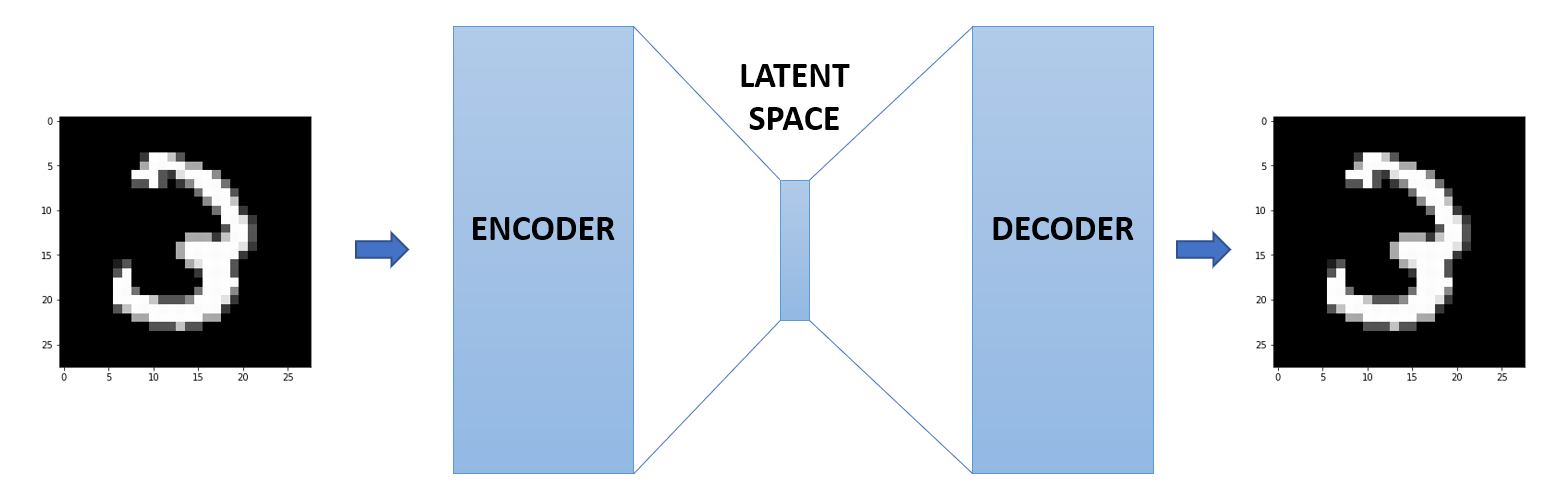

The learning process is described simply as minimizing a loss function $L(x, g(f(x)))$, where $L$ is a loss function penalizing $g(f(x))$ for being dissimilar from $x$, such as the mean squared error.

While the learning is considered to be unsupervised since we are using only the value of $x$, the actual implementation is similar to a supervised setting where the label is just derived from the input.

In [1]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn

# Dataset

## Define the dataset

For this lab. we will use one of the dataset already included in PyTorch ([https://pytorch.org/docs/stable/torchvision/datasets.html#mnist](https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)). These dataset do not require the definition of a custom `Dataset` class, so we can focus on the network implementation.

The MNIST dataset is a colletion of hand-written digits. The size of the images is $28 \times 28$, and there is a single channel only (black and white images).

In [2]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw
Processing...


/Users/Marco/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603729051302/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


The output of the dataset is a PIL Image, a standard format for image processing, but we can easily convert the data to a numpy array:
```
image_numpy = np.array(pil_image)
```
or to a PyTorch tensor:
```
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(pil_image)
```


Let's plot some random samples from the dataset. The first element of the sample is the actual image, while the second is the corresponding label.

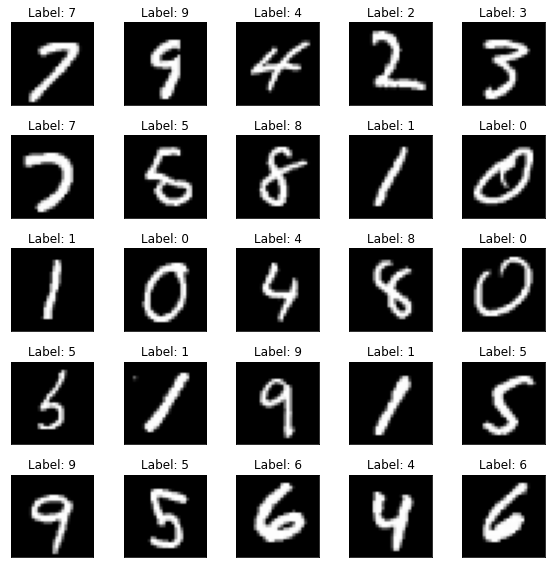

In [3]:
### Plot some sample
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Define the dataset transform

In this example we are using the input images without any modification. As always, the only requirement is to transform the input data to tensors of the proper shape.

In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


Since we already defined our datasets, this is an alternative (and recommended) way to add (or modify) a dataset transformation without reinitializing the dataset (very useful when the dataset initialization is slow):

In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

## Define the dataloader

The dataloader allows to easily create batch of data, in this case we set a batch size of 256, and we also enable data shuffling for the training dataset.

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

## Encoder

Let's start from the encoder. In the figure you can find a suggested architecture for the encoder, with all the required parameters for each layer.

In this example we are considering a latent space with just **2 variables**, so make sure your encoder generates tensors with the proper shape.

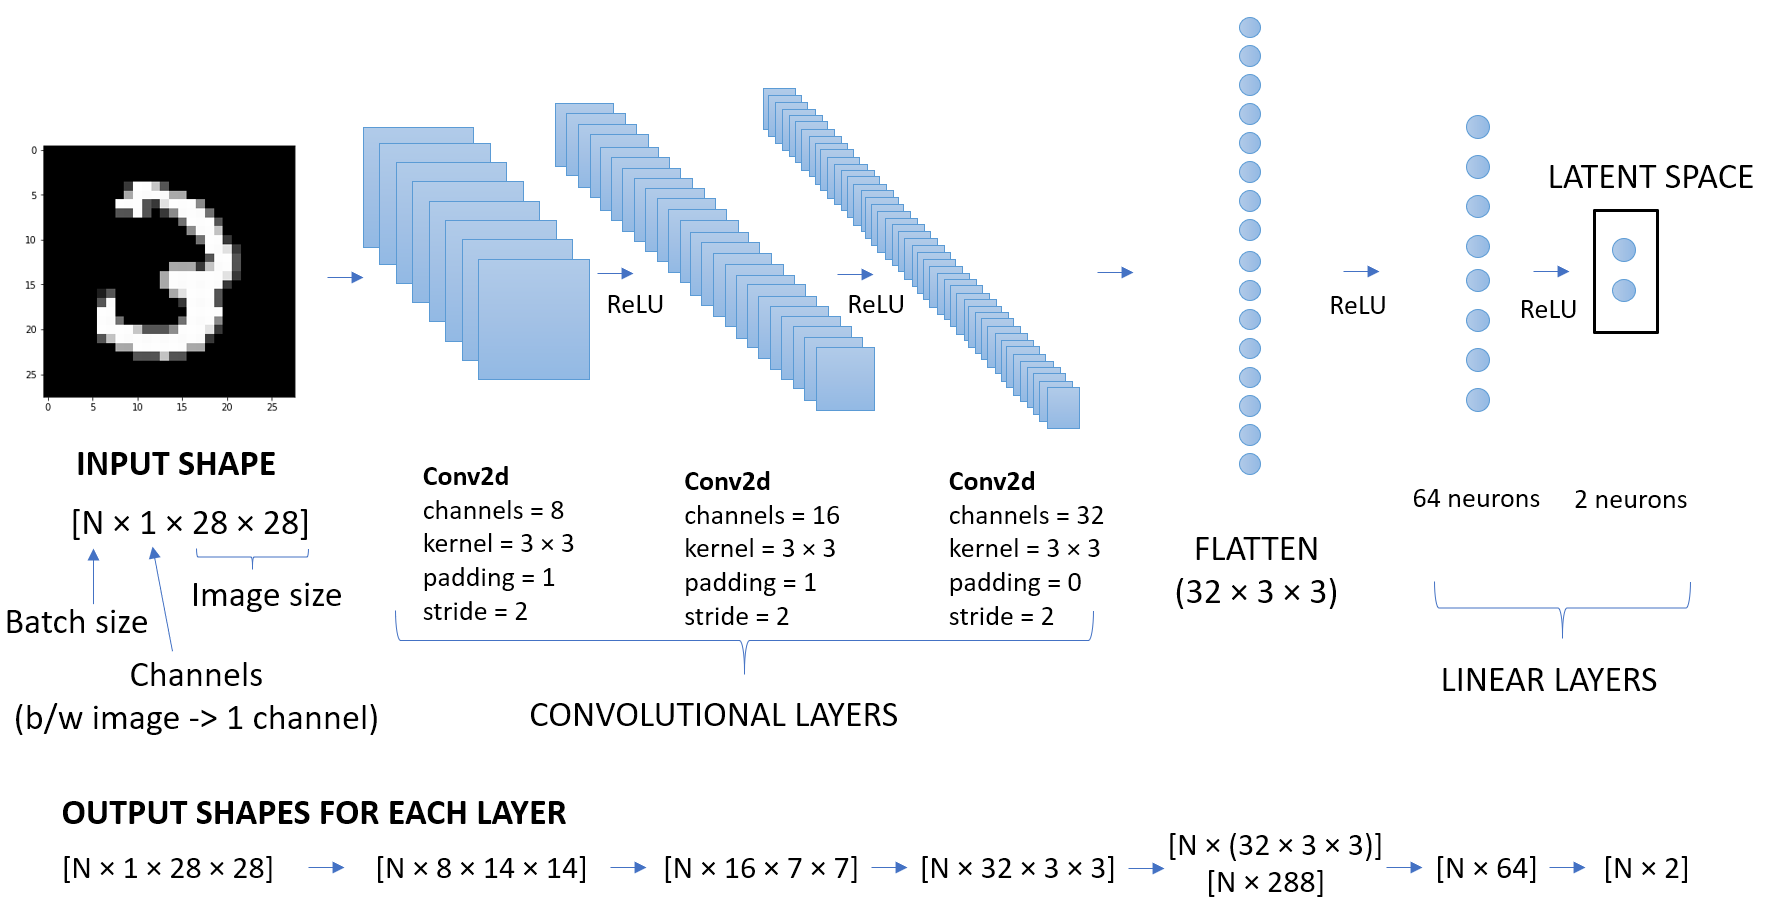

`torch.nn.Sequential` is a utility function that allows to easily concatenate sequential layers, without defining a separate object for each of them (more details here: [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html)).

The output of a convolutional layer is typically multi-dimensional. To apply a linear layer after a convolutional one you should convert your tensor to a monodimensional array. This operation is often referred to as **flattening**. In PyTorch, this can be done with the [`torch.nn.Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html?highlight=flatten#torch.nn.Flatten)
 layer. By setting `start_dim = 1` we keep the first axis (index 0) as it is (which represents the batch size in our case, that should not be flattened) and all the other axes will be flattened in the new second axis.


In [16]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Second convolutional layer
            nn.Conv2d(8, 16, kernel_size=3, padding=1, stride=2),
            nn.ReLU(),
            # Third convolutional layer
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.ReLU(),
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(288, 64),
            nn.ReLU(),
            # Second linear layer
            nn.Linear(64, encoded_space_dim),
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)

        # Flatten
        x = self.flatten(x)
        
        # Apply linear layers
        x = self.encoder_lin(x)
        return x

sample = next(iter(train_dataloader))
sample = sample[0]
print(sample.shape)

encoded_space_dim = 2
enc = Encoder(encoded_space_dim)
out = enc(sample)
print(out.shape)

torch.Size([256, 1, 28, 28])
torch.Size([256, 2])


## Decoder

Typically the structure of the decoder is specular with respect to the encoder, but this is not a strict requirement. Some successfull implementations use very different architectures for the encoder and the decoder. 

The only requirement of the decoder is the input shape, which must match the latent space, and the output shape, that must match the input image. 

In this example we implement a decoder perfectly matched with the encoder architecture, but reversed.

Since the convolutional layers in the encoder perform a down-scaling, we need up-scaling layers in the decoder. To this end we use **transposed convolutions**, already available in PyTorch with the [`torch.nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer.

Similarly to the `torch.nn.Flatten` layer, the [`torch.nn.Unflatten`](https://pytorch.org/docs/stable/generated/torch.nn.Unflatten.html?highlight=unflatten#torch.nn.Unflatten) layer does the opposite operation. We take the axis at index 1 (`dim=1`) and we reshape it to the proper shape (`unflattened_size=(32, 3, 3)`).

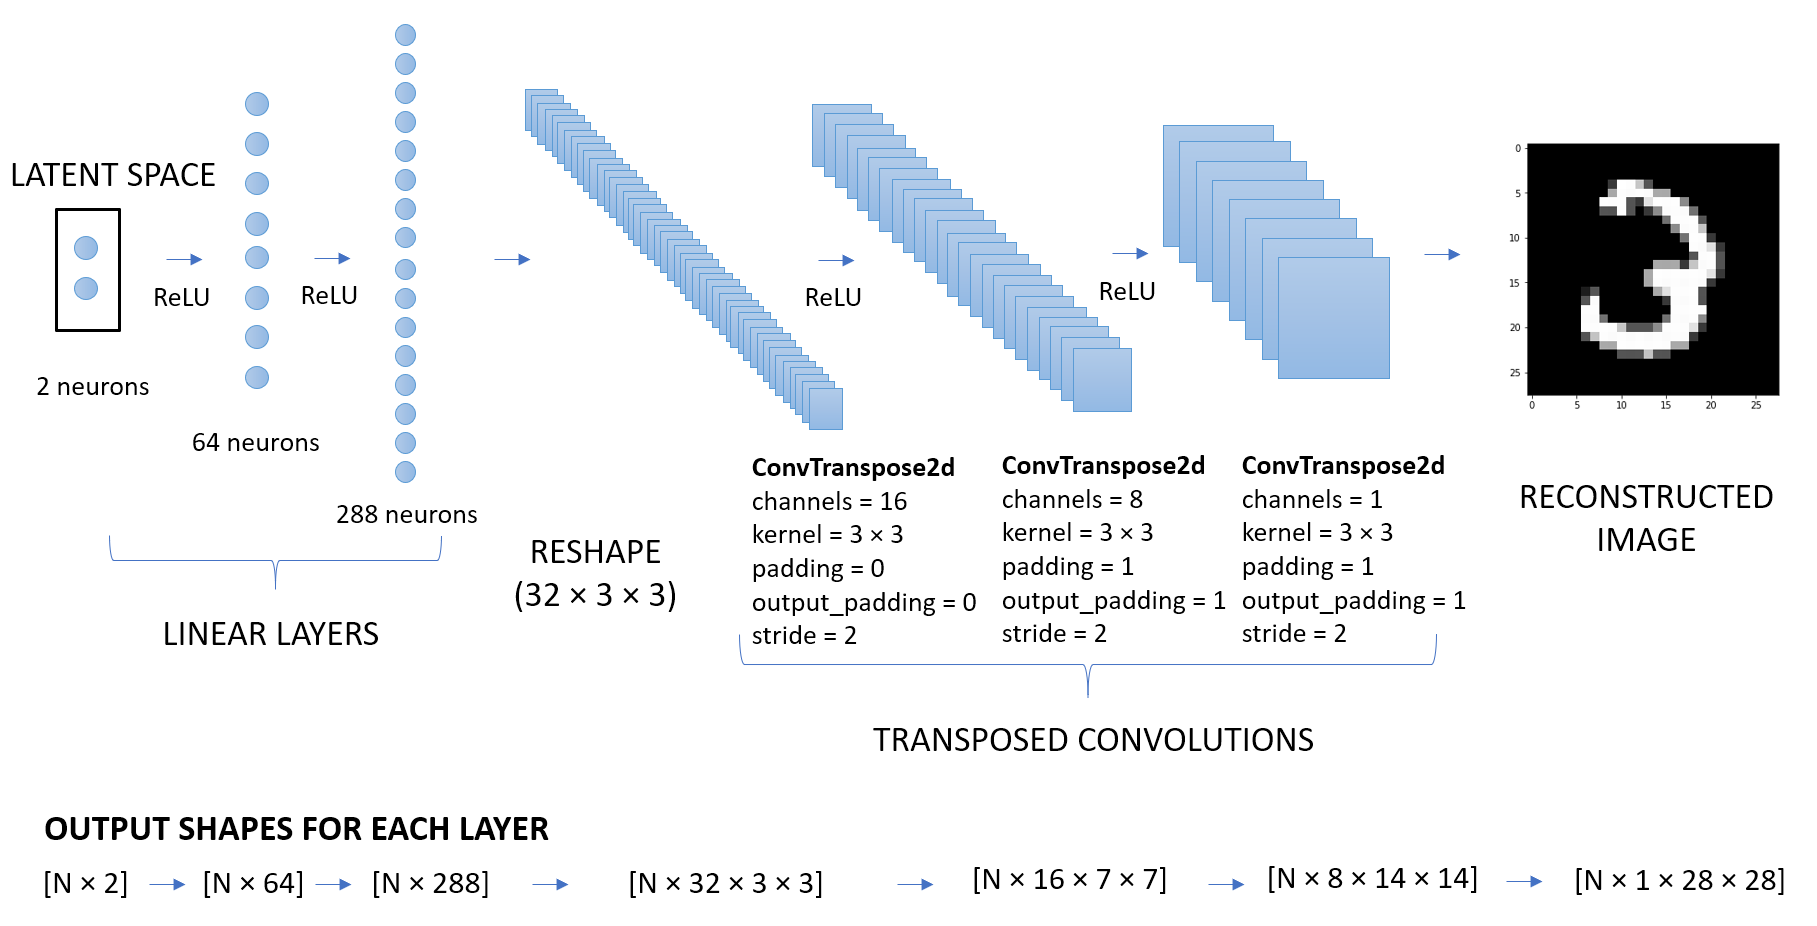

In [23]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(64, 3*3*32), # (64, 288)
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, kernel_size=3, output_padding=0, stride=2),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, kernel_size=3, output_padding=1, padding=1, stride=2),
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)

        # Apply transposed convolutions
        x = self.decoder_conv(x)

        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

Initialize the two networks.

In [24]:
### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
encoded_space_dim = 2
encoder = Encoder(encoded_space_dim=encoded_space_dim)
decoder = Decoder(encoded_space_dim=encoded_space_dim)

Let's check if all the shapes are correct.

In [25]:
### Some examples
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


# Training

The training is similar to the previous examples. The only difference is that now we have 2 different networks. In this situation you have 2 choices:
*   Use a single optimizer to train the parameters of both networks.
*   Define a separate optimizer for each network, and update both of them in the trainin cycle.

In this case we define a single optimizer for both networks, by just providing a list of the required parameters to the optimizer (see the code below).

You can find more details for all the possible scenarios [here](https://pytorch.org/docs/stable/optim.html).

In [26]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 1e-3 # Learning rate
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)

Selected device: cpu


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

## Training function

For a cleaner and more reusable code, we define a training and a testing funcion. This will make the training loop more compact and readable.

The function will train (and test) the network just **for a single epoch**.

In this case, we just track the training loss for each batch. If you want the training loss for the entire epoch, you have to concatenate all the outputs (see the testing function as reference for this case).

In [32]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)

        # Encode data
        encoded_data = encoder.forward(image_batch)

        # Decode data
        decoded_data = decoder.forward( encoded_data )

        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))

## Testing function

In this case, the testing function has the only goal to evaluate how well we are reproducing the input. We quantify this with the average MSE of the entire test set (which in this case correspond to our loss function, but this is not always true).

Since the entire dataset does not always fit in memory, this example shows how to evaluate the network output in batches, aggregating the results (using `conc_out` and `conc_label` in the code). At the end, you can evaluate a  single overall loss.

In [33]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder.forward(image_batch)
            # Decode data
            decoded_data = decoder.forward( encoded_data )
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

## Training loop

Now that we have the training and testing functions, the training loop is considerably simplified. We just need to call these 2 functions for `num_epochs` times.

To see what happen during the training, we also show the output corresponding to a specific image at the end of each epoch.

EPOCH 1/10
	 partial train loss (single batch): 0.246386
	 partial train loss (single batch): 0.245907
	 partial train loss (single batch): 0.245493
	 partial train loss (single batch): 0.243843
	 partial train loss (single batch): 0.243412
	 partial train loss (single batch): 0.243225
	 partial train loss (single batch): 0.242507
	 partial train loss (single batch): 0.241421
	 partial train loss (single batch): 0.240814
	 partial train loss (single batch): 0.240088
	 partial train loss (single batch): 0.238833
	 partial train loss (single batch): 0.237937
	 partial train loss (single batch): 0.236562
	 partial train loss (single batch): 0.235685
	 partial train loss (single batch): 0.235017
	 partial train loss (single batch): 0.232707
	 partial train loss (single batch): 0.231349
	 partial train loss (single batch): 0.230038
	 partial train loss (single batch): 0.228712
	 partial train loss (single batch): 0.227073
	 partial train loss (single batch): 0.225024
	 partial train loss (s

	 partial train loss (single batch): 0.065944
	 partial train loss (single batch): 0.064674
	 partial train loss (single batch): 0.066357
	 partial train loss (single batch): 0.063866
	 partial train loss (single batch): 0.065824
	 partial train loss (single batch): 0.064949
	 partial train loss (single batch): 0.066431
	 partial train loss (single batch): 0.066009
	 partial train loss (single batch): 0.067718
	 partial train loss (single batch): 0.065289
	 partial train loss (single batch): 0.064118
	 partial train loss (single batch): 0.062989
	 partial train loss (single batch): 0.065123
	 partial train loss (single batch): 0.064400
	 partial train loss (single batch): 0.064721
	 partial train loss (single batch): 0.064450
	 partial train loss (single batch): 0.064675
	 partial train loss (single batch): 0.062300
	 partial train loss (single batch): 0.065061
	 partial train loss (single batch): 0.065277
	 partial train loss (single batch): 0.063314
	 partial train loss (single batch

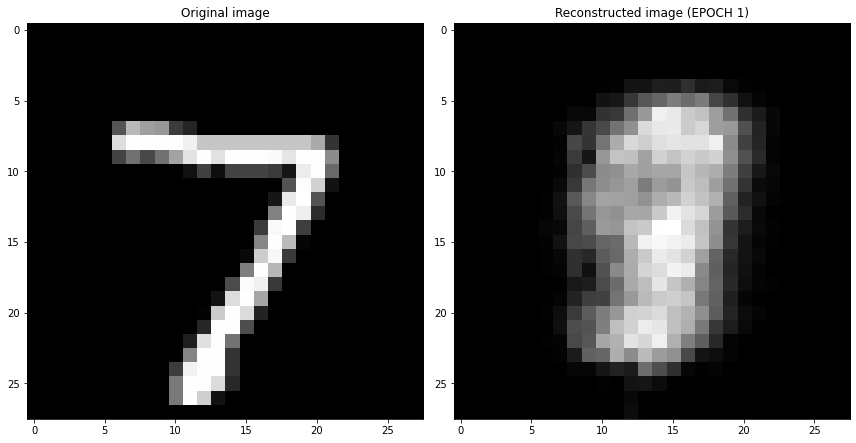

EPOCH 2/10
	 partial train loss (single batch): 0.061736
	 partial train loss (single batch): 0.063380
	 partial train loss (single batch): 0.064365
	 partial train loss (single batch): 0.061605
	 partial train loss (single batch): 0.061082
	 partial train loss (single batch): 0.060618
	 partial train loss (single batch): 0.060103
	 partial train loss (single batch): 0.062323
	 partial train loss (single batch): 0.062142
	 partial train loss (single batch): 0.060703
	 partial train loss (single batch): 0.062348
	 partial train loss (single batch): 0.062600
	 partial train loss (single batch): 0.063588
	 partial train loss (single batch): 0.060703
	 partial train loss (single batch): 0.063899
	 partial train loss (single batch): 0.061746
	 partial train loss (single batch): 0.062381
	 partial train loss (single batch): 0.061051
	 partial train loss (single batch): 0.061164
	 partial train loss (single batch): 0.061411
	 partial train loss (single batch): 0.061222
	 partial train loss (s

	 partial train loss (single batch): 0.059976
	 partial train loss (single batch): 0.055885
	 partial train loss (single batch): 0.055907
	 partial train loss (single batch): 0.058052
	 partial train loss (single batch): 0.059066
	 partial train loss (single batch): 0.058128
	 partial train loss (single batch): 0.056042
	 partial train loss (single batch): 0.060139
	 partial train loss (single batch): 0.058194
	 partial train loss (single batch): 0.056386
	 partial train loss (single batch): 0.057735
	 partial train loss (single batch): 0.056770
	 partial train loss (single batch): 0.057547
	 partial train loss (single batch): 0.058362
	 partial train loss (single batch): 0.058265
	 partial train loss (single batch): 0.057868
	 partial train loss (single batch): 0.056251
	 partial train loss (single batch): 0.058708
	 partial train loss (single batch): 0.058957
	 partial train loss (single batch): 0.057272
	 partial train loss (single batch): 0.057852
	 partial train loss (single batch

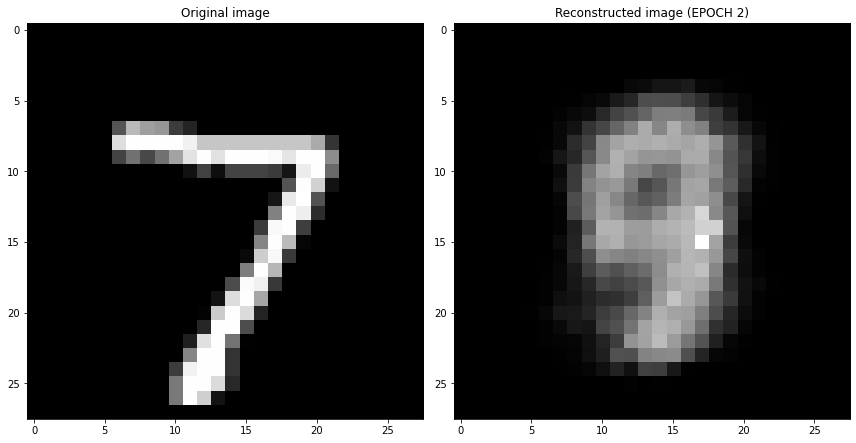

EPOCH 3/10
	 partial train loss (single batch): 0.056464
	 partial train loss (single batch): 0.056407
	 partial train loss (single batch): 0.057501
	 partial train loss (single batch): 0.055592
	 partial train loss (single batch): 0.058473
	 partial train loss (single batch): 0.055179
	 partial train loss (single batch): 0.056851
	 partial train loss (single batch): 0.059544
	 partial train loss (single batch): 0.057589
	 partial train loss (single batch): 0.056266
	 partial train loss (single batch): 0.057661
	 partial train loss (single batch): 0.056855
	 partial train loss (single batch): 0.055216
	 partial train loss (single batch): 0.055886
	 partial train loss (single batch): 0.055980
	 partial train loss (single batch): 0.057711
	 partial train loss (single batch): 0.058082
	 partial train loss (single batch): 0.057332
	 partial train loss (single batch): 0.057657
	 partial train loss (single batch): 0.056703
	 partial train loss (single batch): 0.056940
	 partial train loss (s

	 partial train loss (single batch): 0.054596
	 partial train loss (single batch): 0.054598
	 partial train loss (single batch): 0.055373
	 partial train loss (single batch): 0.054343
	 partial train loss (single batch): 0.055227
	 partial train loss (single batch): 0.053777
	 partial train loss (single batch): 0.055167
	 partial train loss (single batch): 0.053824
	 partial train loss (single batch): 0.053364
	 partial train loss (single batch): 0.056023
	 partial train loss (single batch): 0.054845
	 partial train loss (single batch): 0.054682
	 partial train loss (single batch): 0.054333
	 partial train loss (single batch): 0.054284
	 partial train loss (single batch): 0.054771
	 partial train loss (single batch): 0.053793
	 partial train loss (single batch): 0.055648
	 partial train loss (single batch): 0.056979
	 partial train loss (single batch): 0.054766
	 partial train loss (single batch): 0.054114
	 partial train loss (single batch): 0.053430
	 partial train loss (single batch

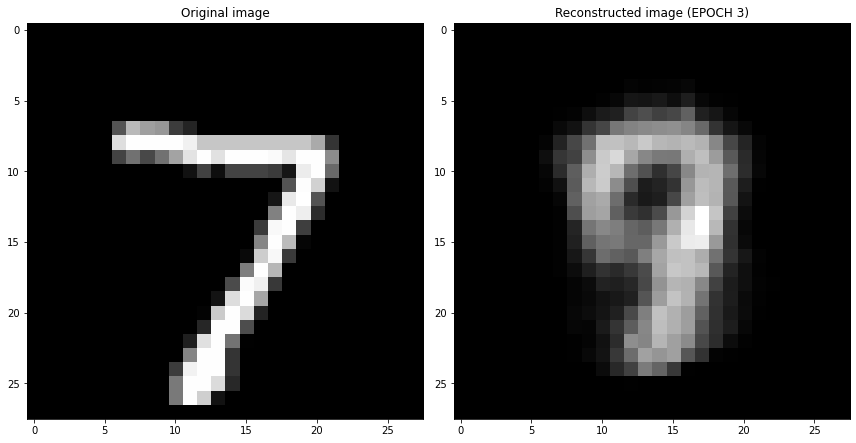

EPOCH 4/10
	 partial train loss (single batch): 0.054696
	 partial train loss (single batch): 0.053070
	 partial train loss (single batch): 0.054148
	 partial train loss (single batch): 0.054230
	 partial train loss (single batch): 0.054496
	 partial train loss (single batch): 0.055978
	 partial train loss (single batch): 0.053587
	 partial train loss (single batch): 0.052873
	 partial train loss (single batch): 0.053594
	 partial train loss (single batch): 0.053878
	 partial train loss (single batch): 0.055186
	 partial train loss (single batch): 0.055268
	 partial train loss (single batch): 0.052588
	 partial train loss (single batch): 0.054330
	 partial train loss (single batch): 0.053054
	 partial train loss (single batch): 0.052800
	 partial train loss (single batch): 0.055231
	 partial train loss (single batch): 0.052283
	 partial train loss (single batch): 0.054004
	 partial train loss (single batch): 0.055610
	 partial train loss (single batch): 0.052815
	 partial train loss (s

	 partial train loss (single batch): 0.052703
	 partial train loss (single batch): 0.053854
	 partial train loss (single batch): 0.053176
	 partial train loss (single batch): 0.052538
	 partial train loss (single batch): 0.052287
	 partial train loss (single batch): 0.051449
	 partial train loss (single batch): 0.055625
	 partial train loss (single batch): 0.052300
	 partial train loss (single batch): 0.051506
	 partial train loss (single batch): 0.051690
	 partial train loss (single batch): 0.054686
	 partial train loss (single batch): 0.052994
	 partial train loss (single batch): 0.050760
	 partial train loss (single batch): 0.051499
	 partial train loss (single batch): 0.051667
	 partial train loss (single batch): 0.052657
	 partial train loss (single batch): 0.052283
	 partial train loss (single batch): 0.054570
	 partial train loss (single batch): 0.051345
	 partial train loss (single batch): 0.052528
	 partial train loss (single batch): 0.053349
	 partial train loss (single batch

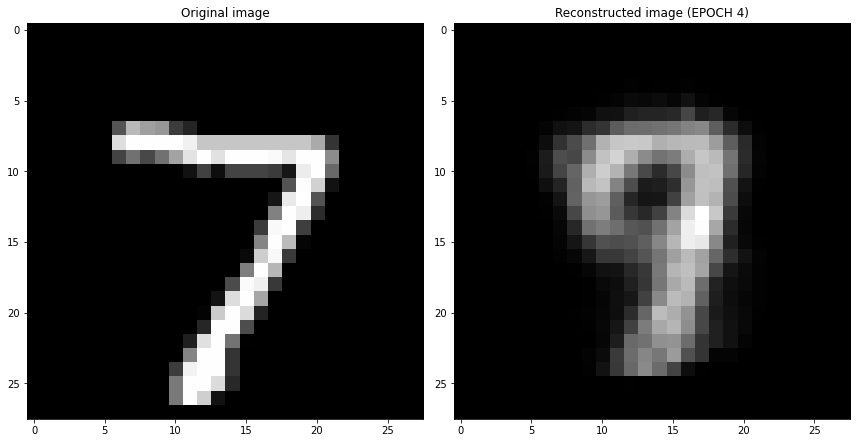

EPOCH 5/10
	 partial train loss (single batch): 0.053949
	 partial train loss (single batch): 0.052148
	 partial train loss (single batch): 0.053190
	 partial train loss (single batch): 0.053358
	 partial train loss (single batch): 0.054615
	 partial train loss (single batch): 0.051329
	 partial train loss (single batch): 0.053491
	 partial train loss (single batch): 0.051412
	 partial train loss (single batch): 0.052604
	 partial train loss (single batch): 0.052467
	 partial train loss (single batch): 0.051762
	 partial train loss (single batch): 0.052704
	 partial train loss (single batch): 0.052934
	 partial train loss (single batch): 0.054366
	 partial train loss (single batch): 0.052678
	 partial train loss (single batch): 0.054060
	 partial train loss (single batch): 0.053717
	 partial train loss (single batch): 0.054142
	 partial train loss (single batch): 0.053997
	 partial train loss (single batch): 0.051696
	 partial train loss (single batch): 0.052971
	 partial train loss (s

	 partial train loss (single batch): 0.048590
	 partial train loss (single batch): 0.050974
	 partial train loss (single batch): 0.051938
	 partial train loss (single batch): 0.050006
	 partial train loss (single batch): 0.050515
	 partial train loss (single batch): 0.052267
	 partial train loss (single batch): 0.051963
	 partial train loss (single batch): 0.049329
	 partial train loss (single batch): 0.053300
	 partial train loss (single batch): 0.051210
	 partial train loss (single batch): 0.052487
	 partial train loss (single batch): 0.053516
	 partial train loss (single batch): 0.051534
	 partial train loss (single batch): 0.052595
	 partial train loss (single batch): 0.052224
	 partial train loss (single batch): 0.051163
	 partial train loss (single batch): 0.050831
	 partial train loss (single batch): 0.052198
	 partial train loss (single batch): 0.050861
	 partial train loss (single batch): 0.052228
	 partial train loss (single batch): 0.054195
	 partial train loss (single batch

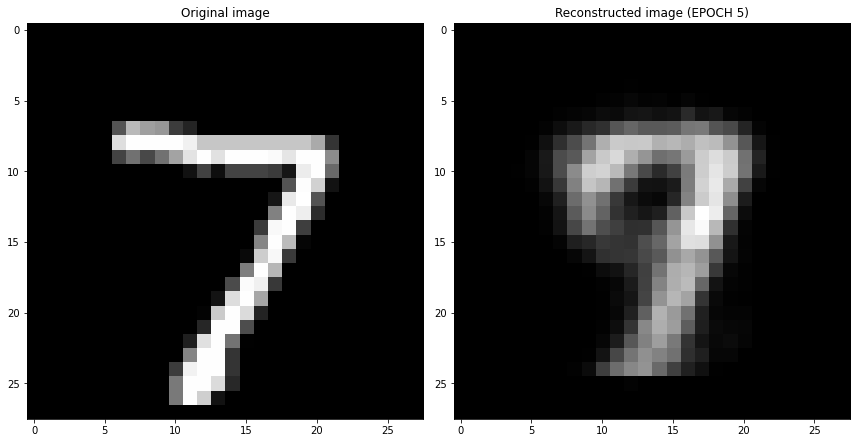

EPOCH 6/10
	 partial train loss (single batch): 0.049980
	 partial train loss (single batch): 0.052549
	 partial train loss (single batch): 0.051993
	 partial train loss (single batch): 0.052357
	 partial train loss (single batch): 0.054606
	 partial train loss (single batch): 0.051494
	 partial train loss (single batch): 0.050689
	 partial train loss (single batch): 0.050854
	 partial train loss (single batch): 0.050708
	 partial train loss (single batch): 0.050330
	 partial train loss (single batch): 0.048452
	 partial train loss (single batch): 0.050447
	 partial train loss (single batch): 0.050537
	 partial train loss (single batch): 0.051257
	 partial train loss (single batch): 0.049602
	 partial train loss (single batch): 0.052737
	 partial train loss (single batch): 0.050072
	 partial train loss (single batch): 0.051818
	 partial train loss (single batch): 0.051508
	 partial train loss (single batch): 0.050161
	 partial train loss (single batch): 0.051600
	 partial train loss (s

	 partial train loss (single batch): 0.050776
	 partial train loss (single batch): 0.050394
	 partial train loss (single batch): 0.051668
	 partial train loss (single batch): 0.048893
	 partial train loss (single batch): 0.049349
	 partial train loss (single batch): 0.050573
	 partial train loss (single batch): 0.049983
	 partial train loss (single batch): 0.053489
	 partial train loss (single batch): 0.051227
	 partial train loss (single batch): 0.051753
	 partial train loss (single batch): 0.050619
	 partial train loss (single batch): 0.050305
	 partial train loss (single batch): 0.048729
	 partial train loss (single batch): 0.049810
	 partial train loss (single batch): 0.049905
	 partial train loss (single batch): 0.049228
	 partial train loss (single batch): 0.051827
	 partial train loss (single batch): 0.050098
	 partial train loss (single batch): 0.050025
	 partial train loss (single batch): 0.050608
	 partial train loss (single batch): 0.049766
	 partial train loss (single batch

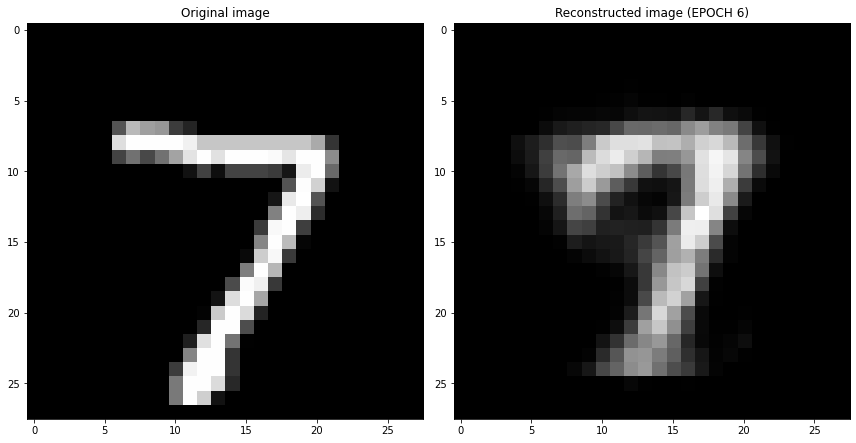

EPOCH 7/10
	 partial train loss (single batch): 0.050643
	 partial train loss (single batch): 0.048183
	 partial train loss (single batch): 0.050817
	 partial train loss (single batch): 0.049854
	 partial train loss (single batch): 0.050044
	 partial train loss (single batch): 0.050964
	 partial train loss (single batch): 0.049494
	 partial train loss (single batch): 0.049002
	 partial train loss (single batch): 0.051388
	 partial train loss (single batch): 0.050539
	 partial train loss (single batch): 0.050134
	 partial train loss (single batch): 0.051705
	 partial train loss (single batch): 0.049494
	 partial train loss (single batch): 0.050739
	 partial train loss (single batch): 0.048550
	 partial train loss (single batch): 0.050541
	 partial train loss (single batch): 0.050670
	 partial train loss (single batch): 0.049487
	 partial train loss (single batch): 0.048743
	 partial train loss (single batch): 0.049922
	 partial train loss (single batch): 0.049236
	 partial train loss (s

	 partial train loss (single batch): 0.047298
	 partial train loss (single batch): 0.048017
	 partial train loss (single batch): 0.046478
	 partial train loss (single batch): 0.048637
	 partial train loss (single batch): 0.048151
	 partial train loss (single batch): 0.048219
	 partial train loss (single batch): 0.047823
	 partial train loss (single batch): 0.047467
	 partial train loss (single batch): 0.047544
	 partial train loss (single batch): 0.048283
	 partial train loss (single batch): 0.046391
	 partial train loss (single batch): 0.047787
	 partial train loss (single batch): 0.047648
	 partial train loss (single batch): 0.048208
	 partial train loss (single batch): 0.047944
	 partial train loss (single batch): 0.050054
	 partial train loss (single batch): 0.048368
	 partial train loss (single batch): 0.050347
	 partial train loss (single batch): 0.050162
	 partial train loss (single batch): 0.049377
	 partial train loss (single batch): 0.047471
	 partial train loss (single batch

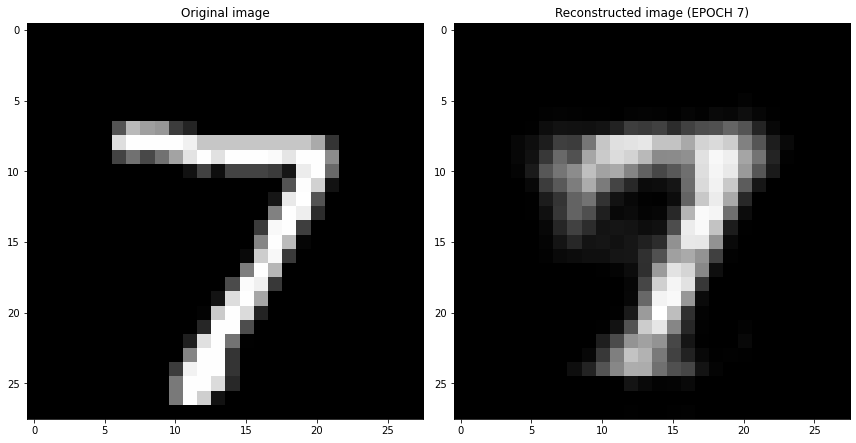

EPOCH 8/10
	 partial train loss (single batch): 0.047942
	 partial train loss (single batch): 0.046237
	 partial train loss (single batch): 0.046908
	 partial train loss (single batch): 0.048455
	 partial train loss (single batch): 0.048748
	 partial train loss (single batch): 0.047881
	 partial train loss (single batch): 0.048790
	 partial train loss (single batch): 0.049595
	 partial train loss (single batch): 0.048792
	 partial train loss (single batch): 0.047619
	 partial train loss (single batch): 0.048176
	 partial train loss (single batch): 0.049227
	 partial train loss (single batch): 0.049849
	 partial train loss (single batch): 0.048838
	 partial train loss (single batch): 0.047939
	 partial train loss (single batch): 0.047172
	 partial train loss (single batch): 0.049088
	 partial train loss (single batch): 0.048710
	 partial train loss (single batch): 0.051142
	 partial train loss (single batch): 0.048937
	 partial train loss (single batch): 0.048521
	 partial train loss (s

	 partial train loss (single batch): 0.049211
	 partial train loss (single batch): 0.047414
	 partial train loss (single batch): 0.047523
	 partial train loss (single batch): 0.047635
	 partial train loss (single batch): 0.047752
	 partial train loss (single batch): 0.048315
	 partial train loss (single batch): 0.047563
	 partial train loss (single batch): 0.046684
	 partial train loss (single batch): 0.046468
	 partial train loss (single batch): 0.045917
	 partial train loss (single batch): 0.045937
	 partial train loss (single batch): 0.047311
	 partial train loss (single batch): 0.048532
	 partial train loss (single batch): 0.048632
	 partial train loss (single batch): 0.046307
	 partial train loss (single batch): 0.045202
	 partial train loss (single batch): 0.046798
	 partial train loss (single batch): 0.047737
	 partial train loss (single batch): 0.049159
	 partial train loss (single batch): 0.047834
	 partial train loss (single batch): 0.045734
	 partial train loss (single batch

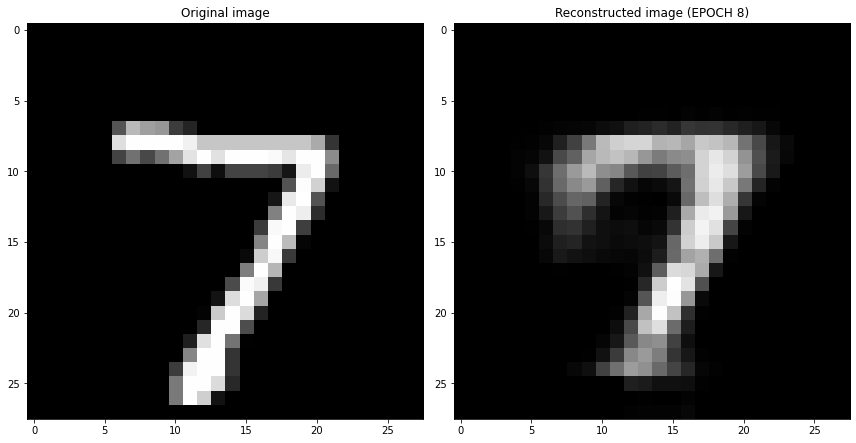

EPOCH 9/10
	 partial train loss (single batch): 0.045726
	 partial train loss (single batch): 0.045958
	 partial train loss (single batch): 0.045171
	 partial train loss (single batch): 0.045807
	 partial train loss (single batch): 0.048674
	 partial train loss (single batch): 0.045123
	 partial train loss (single batch): 0.048562
	 partial train loss (single batch): 0.049232
	 partial train loss (single batch): 0.046888
	 partial train loss (single batch): 0.046530
	 partial train loss (single batch): 0.047438
	 partial train loss (single batch): 0.047760
	 partial train loss (single batch): 0.047062
	 partial train loss (single batch): 0.045466
	 partial train loss (single batch): 0.046289
	 partial train loss (single batch): 0.048243
	 partial train loss (single batch): 0.046869
	 partial train loss (single batch): 0.046410
	 partial train loss (single batch): 0.046671
	 partial train loss (single batch): 0.047157
	 partial train loss (single batch): 0.046186
	 partial train loss (s

	 partial train loss (single batch): 0.045456
	 partial train loss (single batch): 0.045122
	 partial train loss (single batch): 0.045010
	 partial train loss (single batch): 0.046595
	 partial train loss (single batch): 0.045733
	 partial train loss (single batch): 0.044890
	 partial train loss (single batch): 0.048889
	 partial train loss (single batch): 0.047407
	 partial train loss (single batch): 0.048431
	 partial train loss (single batch): 0.046418
	 partial train loss (single batch): 0.045035
	 partial train loss (single batch): 0.044041
	 partial train loss (single batch): 0.045006
	 partial train loss (single batch): 0.044849
	 partial train loss (single batch): 0.046474
	 partial train loss (single batch): 0.044465
	 partial train loss (single batch): 0.044675
	 partial train loss (single batch): 0.044220
	 partial train loss (single batch): 0.043557
	 partial train loss (single batch): 0.047087
	 partial train loss (single batch): 0.044957
	 partial train loss (single batch

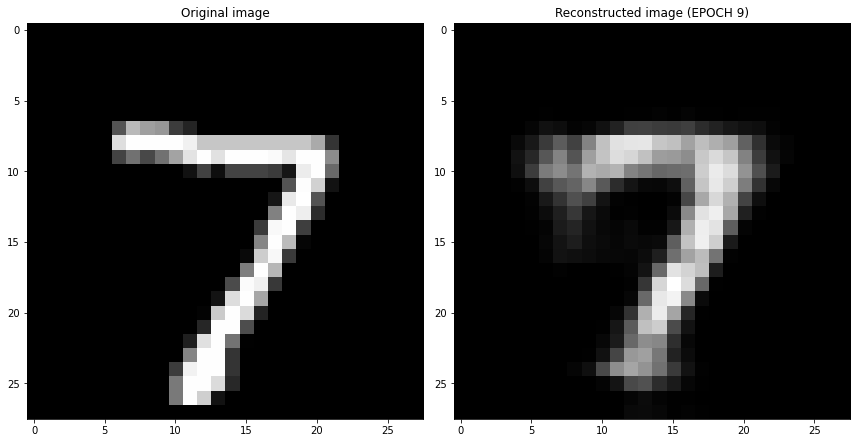

EPOCH 10/10
	 partial train loss (single batch): 0.048369
	 partial train loss (single batch): 0.044770
	 partial train loss (single batch): 0.044443
	 partial train loss (single batch): 0.044776
	 partial train loss (single batch): 0.045634
	 partial train loss (single batch): 0.043788
	 partial train loss (single batch): 0.043360
	 partial train loss (single batch): 0.046980
	 partial train loss (single batch): 0.043162
	 partial train loss (single batch): 0.045742
	 partial train loss (single batch): 0.043346
	 partial train loss (single batch): 0.045727
	 partial train loss (single batch): 0.047467
	 partial train loss (single batch): 0.045882
	 partial train loss (single batch): 0.043292
	 partial train loss (single batch): 0.047227
	 partial train loss (single batch): 0.047754
	 partial train loss (single batch): 0.044878
	 partial train loss (single batch): 0.044495
	 partial train loss (single batch): 0.046691
	 partial train loss (single batch): 0.045643
	 partial train loss (

	 partial train loss (single batch): 0.044560
	 partial train loss (single batch): 0.046217
	 partial train loss (single batch): 0.046337
	 partial train loss (single batch): 0.045164
	 partial train loss (single batch): 0.045563
	 partial train loss (single batch): 0.043094
	 partial train loss (single batch): 0.046640
	 partial train loss (single batch): 0.045248
	 partial train loss (single batch): 0.043360
	 partial train loss (single batch): 0.047039
	 partial train loss (single batch): 0.045154
	 partial train loss (single batch): 0.043711
	 partial train loss (single batch): 0.044864
	 partial train loss (single batch): 0.044147
	 partial train loss (single batch): 0.046577
	 partial train loss (single batch): 0.046043
	 partial train loss (single batch): 0.044693
	 partial train loss (single batch): 0.044262
	 partial train loss (single batch): 0.043463
	 partial train loss (single batch): 0.045983
	 partial train loss (single batch): 0.045096
	 partial train loss (single batch

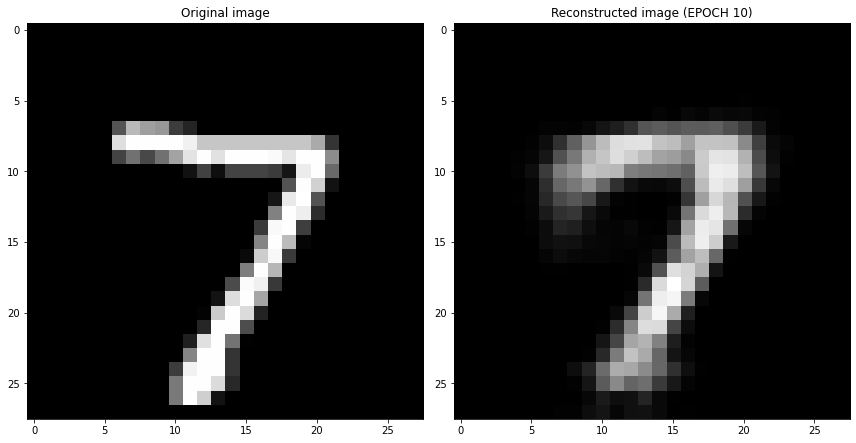

In [34]:
### Training cycle
num_epochs = 10
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    ### Validation  (use the testing function)
    val_loss = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=test_dataloader, 
        loss_fn=loss_fn)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        rec_img  = decoder(encoder(img))
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(encoder.state_dict(), 'encoder_params.pth')
    torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

# Network Analysis

If you have a previously saved network, restore the network parameters.

In [35]:
# Load network parameters
encoder.load_state_dict(torch.load('encoder_params.pth'))
decoder.load_state_dict(torch.load('decoder_params.pth'))

<All keys matched successfully>

The encoder can be used to evaluate the latent space values for each of the test images. Since we used an encoded space dimension of 2, the encoder maps an entire image to just 2 floating point numbers.

We also save the corresponding label to show how each digit is mapped in the encoded space.

In [36]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:18<00:00, 545.11it/s]


For convenience (not required), convert the result to a table format (`pandas.DataFrame`):

In [37]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,-31.343849,13.301747,7
1,0.042136,-5.040908,2
2,-47.531490,-30.731922,1
3,0.651326,5.680066,0
4,-12.436500,9.239423,4
...,...,...,...
9995,6.163315,-17.441011,2
9996,-3.785438,-0.212568,3
9997,-14.644049,4.719799,4
9998,-3.589921,-5.130129,5


This graph shows where each input image is mapped in the encoded space. Since we have just 2 encoded variables, we can easily plot them in a bidimensional space. 

In [41]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

As you can see from the graph, even if we never used the labels (i.e. the actual digit written in the image) during the training, the network has been able to clusterize quite well the different classes.

> **NOTE**
> 
> The encoded space may have many more variables. In this case you can still have a visual representation of the encoded space by applying a dimensionality reduction method, such as:
- [Princiapal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)
- [t-distributed Stochastic Neighbor Embedding (t-SNE)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)




While the encoder is able to map the image to the encoded space, the decoder can do the opposite, generating an image given the corresponding latent space values.

The latent space can also be manually customized, like in the following example, where we generate images with the decoder by providing custom latent space variables.

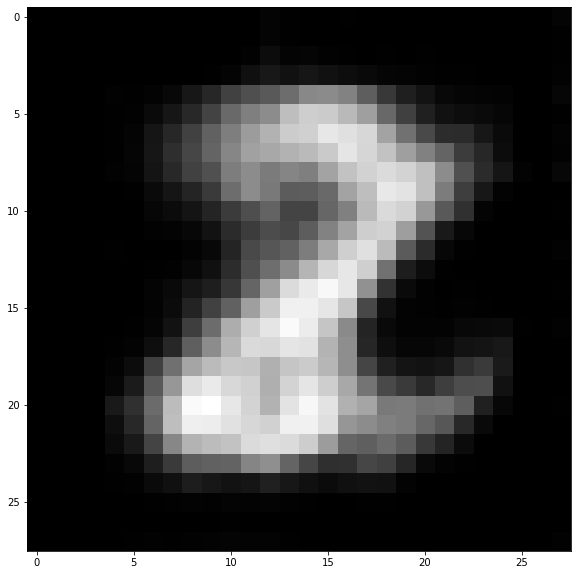

In [50]:
if encoded_space_dim == 2:
    # Generate a custom sample
    custom_encoded_sample = [0, -10.0]
    encoded_value = torch.tensor(custom_encoded_sample).float().unsqueeze(0).to(device)

    # Decode sample
    decoder.eval()
    with torch.no_grad():
        generated_img  = decoder(encoded_value)

    plt.figure(figsize=(12,10))
    plt.imshow(generated_img.squeeze().cpu().numpy(), cmap='gist_gray')
    plt.show()

To denoise add additional transformation that add noise. 